<a href="https://colab.research.google.com/github/mykhailodolitsoi/EDU_pytorch/blob/main/03_pytorch_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.modules.pooling import MaxPool2d
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

!pip install torchmetrics
import torchmetrics

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.3 MB/s eta 0:00:00


In [51]:
### HELPER FUNCTIONS SECTION
def make_preds()

def make_probs(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            pred_logit = model(sample)

            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def train_test_step(model: torch.nn.Module,
                dataloader:torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                epoch: int,
                epochs: int,
                accuracy_fn=accuracy_fn,
                optimizer: torch.optim.Optimizer = None,
                devide: torch.device = device,
                train: bool = False):
    acc_train, loss_train_sum = 0, 0

    if train == True:
        for X, y in dataloader:
            model.train()

            X, y = X.to(device), y.to(device)

            y_pred_train = model(X)

            loss_train = loss_fn(y_pred_train, y)
            loss_train_sum += loss_train
            acc_train += accuracy_fn(y, y_pred_train.argmax(dim=1))

            optimizer.zero_grad()

            loss_train.backward()

            optimizer.step()

        print(f"EPOCH: {epoch+1}/{epochs} | ACC_TRAIN: {acc_train/len(dataloader):.4f} | LOSS_TRAIN: {loss_train/len(dataloader):.4f}")

    else:
        acc_test, loss_test_sum = 0, 0

        for X, y in dataloader:
            with torch.inference_mode():
                model.eval()

                X, y = X.to(device), y.to(device)

                y_pred_test = model(X)

                loss_test = loss_fn(y_pred_test, y)
                loss_test_sum += loss_test
                acc_test += accuracy_fn(y, y_pred_test.argmax(dim=1))

                # if epoch+1 == epochs:
                #     print(y == y_pred_test.argmax(dim=1))

        print(f"EPOCH: {epoch+1}/{epochs} | ACC_TEST: {acc_test/len(dataloader):.4f} | LOSS_TEST: {loss_test/len(dataloader):.4f}")
        return y_pred_test

In [3]:
torch.manual_seed(7)
torch.cuda.manual_seed(7)

### DATA SECTION

# Downloading data from torchvision.datasets
data_train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

data_test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

class_names = data_train.classes
class_to_idx = data_train.class_to_idx
class_to_idx

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.80MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 24.8MB/s]


{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

IMAGE SHAPE: torch.Size([1, 28, 28])


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

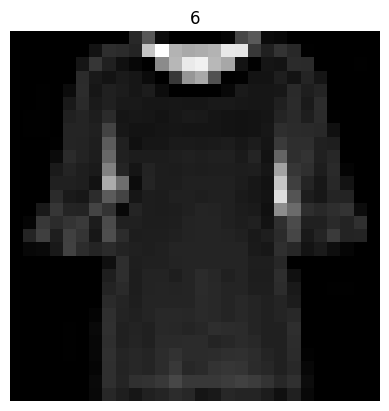

In [4]:
# visualize the data

image, label = data_train[np.random.randint(0, len(data_train))]
print(f"IMAGE SHAPE: {image.shape}")

plt.imshow(image.squeeze(), cmap='gray')
plt.title(label)
plt.axis(False)

In [5]:
# Prepare dataloader
BATCH_SIZE = 32

dataloader_train = DataLoader(dataset=data_train,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

dataloader_test = DataLoader(dataset=data_test,
                              batch_size=BATCH_SIZE,
                              shuffle=False)
len(dataloader_test)

313

In [6]:
### MODEL SECTION

class model(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int,
                 kernel_size: int,
                 padding: int):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=padding),
            nn.ReLU(),

            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=padding),
            nn.ReLU(),

            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=padding),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2)

        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x

In [7]:
torch.manual_seed(7)
torch.cuda.manual_seed(7)

model = model(input_shape=1,
               hidden_units=128,
               output_shape=10,
               kernel_size=3,
               padding=1)

In [34]:
# Training/ testing
epochs = 10

loss_fn = nn.CrossEntropyLoss()

model = model.to(device)
optim = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(epochs):
    train_test_step(model=model,
                dataloader=dataloader_train,
                loss_fn=loss_fn,
                optimizer=optim,
                epoch=epoch,
                epochs=epochs,
                train=True)
    y_pred = train_test_step(model=model,
                dataloader=dataloader_test,
                loss_fn=loss_fn,
                epoch=epoch,
                epochs=epochs,
                train=False)

EPOCH: 1/10 | ACC_TRAIN: 98.1383 | LOSS_TRAIN: 0.0000
EPOCH: 1/10 | ACC_TEST: 90.7448 | LOSS_TEST: 0.0000
EPOCH: 2/10 | ACC_TRAIN: 97.9633 | LOSS_TRAIN: 0.0001
EPOCH: 2/10 | ACC_TEST: 90.9944 | LOSS_TEST: 0.0000
EPOCH: 3/10 | ACC_TRAIN: 98.0500 | LOSS_TRAIN: 0.0000
EPOCH: 3/10 | ACC_TEST: 90.7648 | LOSS_TEST: 0.0007
EPOCH: 4/10 | ACC_TRAIN: 97.9933 | LOSS_TRAIN: 0.0001
EPOCH: 4/10 | ACC_TEST: 90.7748 | LOSS_TEST: 0.0010
EPOCH: 5/10 | ACC_TRAIN: 98.2600 | LOSS_TRAIN: 0.0000
EPOCH: 5/10 | ACC_TEST: 91.4038 | LOSS_TEST: 0.0007
EPOCH: 6/10 | ACC_TRAIN: 98.1050 | LOSS_TRAIN: 0.0000
EPOCH: 6/10 | ACC_TEST: 90.6649 | LOSS_TEST: 0.0000
EPOCH: 7/10 | ACC_TRAIN: 98.1500 | LOSS_TRAIN: 0.0000
EPOCH: 7/10 | ACC_TEST: 91.2440 | LOSS_TEST: 0.0007
EPOCH: 8/10 | ACC_TRAIN: 98.3567 | LOSS_TRAIN: 0.0000
EPOCH: 8/10 | ACC_TEST: 90.7149 | LOSS_TEST: 0.0000
EPOCH: 9/10 | ACC_TRAIN: 98.4417 | LOSS_TRAIN: 0.0000
EPOCH: 9/10 | ACC_TEST: 91.4437 | LOSS_TEST: 0.0010
EPOCH: 10/10 | ACC_TRAIN: 98.1800 | LOSS_TRAIN

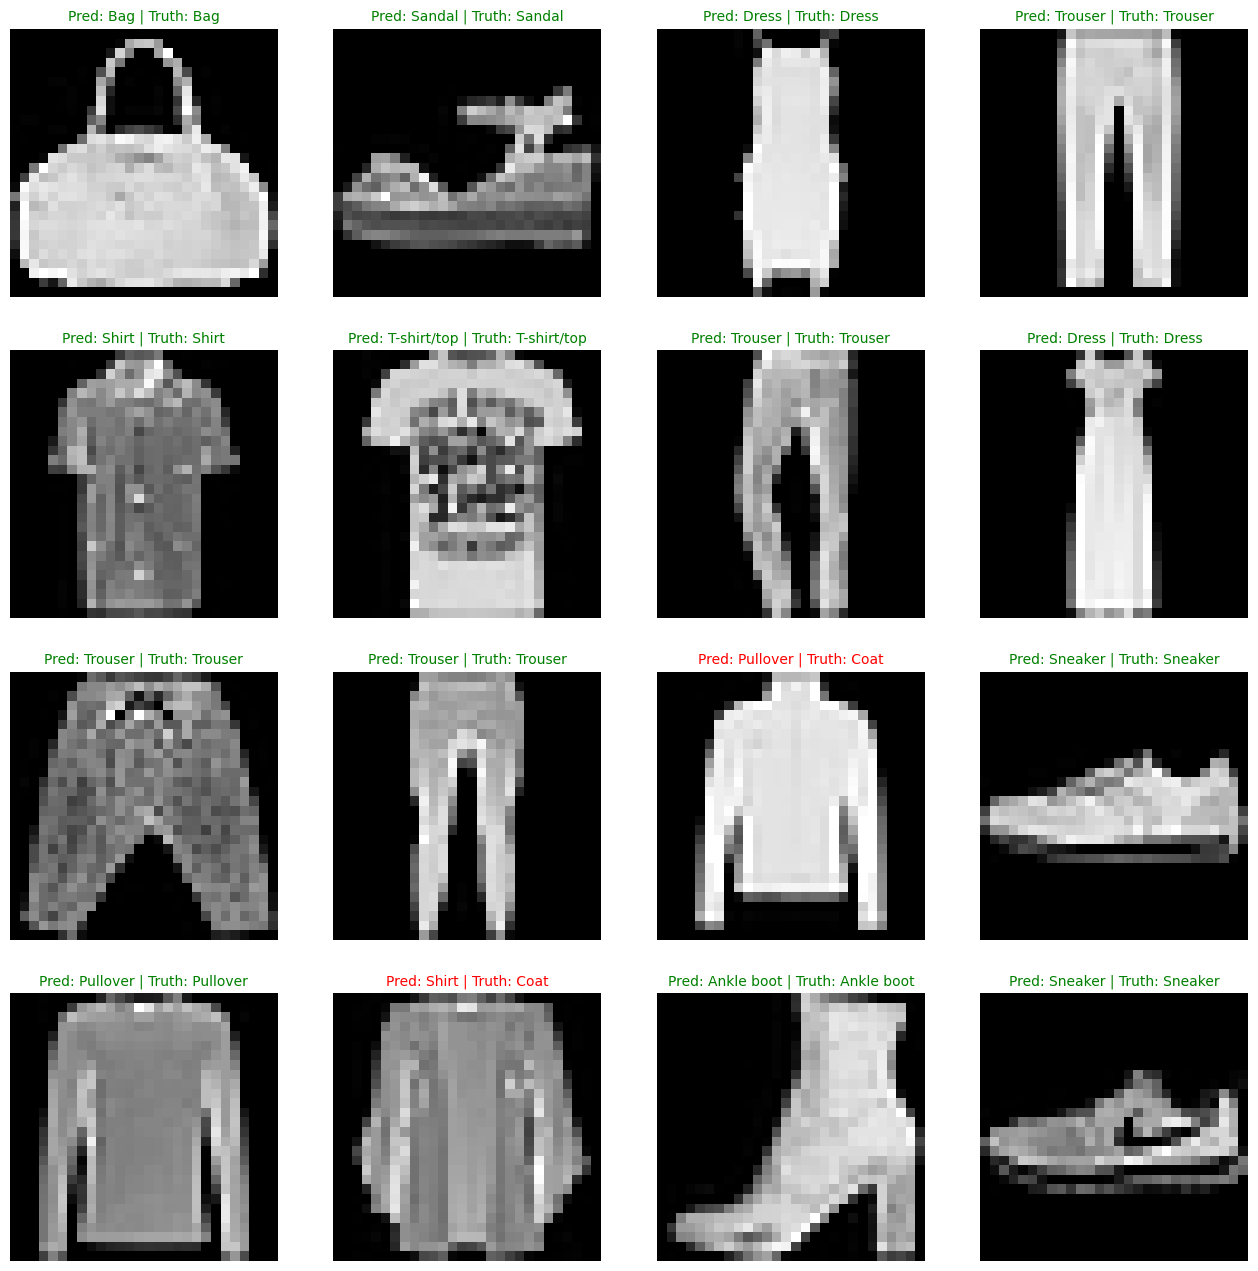

In [47]:
### PLOT SECTION

random.seed(7)

samples_test = []
labels_test = []
for sample, label in random.sample(list(data_test), k=16):
    samples_test.append(sample)
    labels_test.append(label)

pred_probs= make_probs(model=model,
                             data=samples_test)
pred_classes = pred_probs.argmax(dim=1)

plt.figure(figsize=(16, 16))
nrows = 4
ncols = 4
for i, sample in enumerate(samples_test):
  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.squeeze(), cmap="gray")

  pred_label = class_names[pred_classes[i]]

  truth_label = class_names[labels_test[i]]

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g")
  else:
      plt.title(title_text, fontsize=10, c="r")
  plt.axis(False);

In [53]:
from tqdm.auto import tqdm

y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(dataloader_test, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

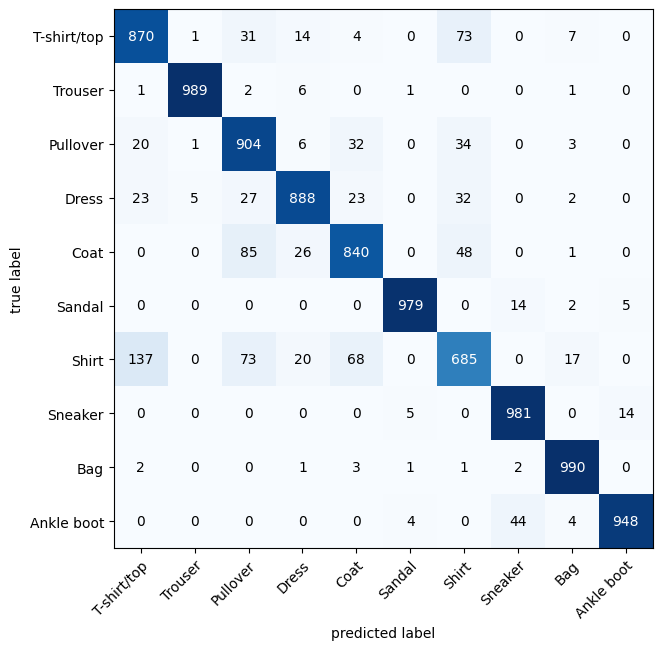

In [55]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=data_test.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);
